This tutorial can be found here: https://sagemaker-examples.readthedocs.io/en/latest/sagemaker_processing/fairness_and_explainability/fairness_and_explainability.html#Overview

In [ ]:


from sagemaker import Session

session = Session()
bucket = session.default_bucket()
prefix = "sagemaker/DEMO-sagemaker-clarify"
region = session.boto_region_name
# Define IAM role
from sagemaker import get_execution_role
import pandas as pd
import numpy as np
import os
import boto3

role = get_execution_role()
s3_client = boto3.client("s3")

In [3]:
# Downloading and prepping dataset

adult_columns = [
    "Age",
    "Workclass",
    "fnlwgt",
    "Education",
    "Education-Num",
    "Marital Status",
    "Occupation",
    "Relationship",
    "Ethnic group",
    "Sex",
    "Capital Gain",
    "Capital Loss",
    "Hours per week",
    "Country",
    "Target",
]
if not os.path.isfile("adult.data"):
    s3_client.download_file(
        "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.data", "adult.data"
    )
    print("adult.data saved!")
else:
    print("adult.data already on disk.")

if not os.path.isfile("adult.test"):
    s3_client.download_file(
        "sagemaker-sample-files", "datasets/tabular/uci_adult/adult.test", "adult.test"
    )
    print("adult.test saved!")
else:
    print("adult.test already on disk.")

adult.data saved!
adult.test saved!


In [4]:
# Specify binary prediction task

training_data = pd.read_csv(
    "adult.data", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?"
).dropna()

testing_data = pd.read_csv(
    "adult.test", names=adult_columns, sep=r"\s*,\s*", engine="python", na_values="?", skiprows=1
).dropna()

training_data.head()

,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


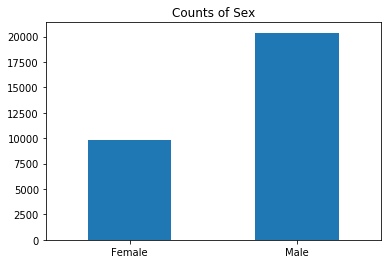

In [5]:
# Plot histograms for data inspection

training_data["Sex"].value_counts().sort_values().plot(kind="bar", title="Counts of Sex", rot=0)

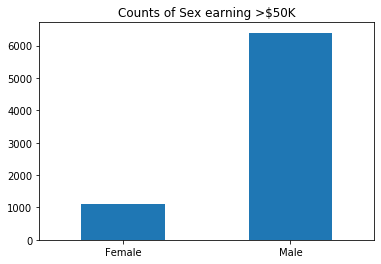

In [6]:
training_data["Sex"].where(training_data["Target"] == ">50K").value_counts().sort_values().plot(
    kind="bar", title="Counts of Sex earning >$50K", rot=0
)

In [7]:
# Encode and upload the data

from sklearn import preprocessing


def number_encode_features(df):
    result = df.copy()
    encoders = {}
    for column in result.columns:
        if result.dtypes[column] == np.object:
            encoders[column] = preprocessing.LabelEncoder()
            result[column] = encoders[column].fit_transform(result[column].fillna("None"))
    return result, encoders


training_data = pd.concat([training_data["Target"], training_data.drop(["Target"], axis=1)], axis=1)
training_data, _ = number_encode_features(training_data)
training_data.to_csv("train_data.csv", index=False, header=False)

testing_data, _ = number_encode_features(testing_data)
test_features = testing_data.drop(["Target"], axis=1)
test_target = testing_data["Target"]
test_features.to_csv("test_features.csv", index=False, header=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [8]:
# Review training set to ensure encoding

training_data.head()

,Target,Age,Workclass,fnlwgt,Education,Education-Num,Marital Status,Occupation,Relationship,Ethnic group,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38
1,0,50,4,83311,9,13,2,3,0,4,1,0,0,13,38
2,0,38,2,215646,11,9,0,5,1,4,1,0,0,40,38
3,0,53,2,234721,1,7,2,5,0,2,1,0,0,40,38
4,0,28,2,338409,9,13,2,9,5,2,0,0,0,40,4


In [9]:
# Upload data to S3 bucket

from sagemaker.s3 import S3Uploader
from sagemaker.inputs import TrainingInput

train_uri = S3Uploader.upload("train_data.csv", "s3://{}/{}".format(bucket, prefix))
train_input = TrainingInput(train_uri, content_type="csv")
test_uri = S3Uploader.upload("test_features.csv", "s3://{}/{}".format(bucket, prefix))

## Moving to Training model

In [10]:
from sagemaker.image_uris import retrieve
from sagemaker.estimator import Estimator

container = retrieve("xgboost", region, version="1.2-1")
xgb = Estimator(
    container,
    role,
    instance_count=1,
    instance_type="ml.m5.xlarge",
    disable_profiler=True,
    sagemaker_session=session,
)

xgb.set_hyperparameters(
    max_depth=5,m
    eta=0.2,
    gamma=4,
    min_child_weight=6,
    subsample=0.8,
    objective="binary:logistic",
    num_round=800,
)

xgb.fit({"train": train_input}, logs=False)


2022-04-16 15:08:41 Starting - Starting the training job...
2022-04-16 15:08:57 Starting - Preparing the instances for training.............
2022-04-16 15:10:11 Downloading - Downloading input data...
2022-04-16 15:10:31 Training - Downloading the training image............
2022-04-16 15:11:32 Training - Training image download completed. Training in progress......
2022-04-16 15:12:03 Uploading - Uploading generated training model
2022-04-16 15:12:08 Completed - Training job completed


In [11]:
# Create sagemaker model

model_name = "DEMO-clarify-model"
model = xgb.create_model(name=model_name)
container_def = model.prepare_container_def()
session.create_model(model_name, role, container_def)

'DEMO-clarify-model'

### Bring in clarify

In [12]:
from sagemaker import clarify

clarify_processor = clarify.SageMakerClarifyProcessor(
    role=role, instance_count=1, instance_type="ml.m5.xlarge", sagemaker_session=session
)

In [13]:
# detect bias

bias_report_output_path = "s3://{}/{}/clarify-bias".format(bucket, prefix)
bias_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=bias_report_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [14]:
model_config = clarify.ModelConfig(
    model_name=model_name,
    instance_type="ml.m5.xlarge",
    instance_count=1,
    accept_type="text/csv",
    content_type="text/csv",
)

In [15]:
# Predictions

predictions_config = clarify.ModelPredictedLabelConfig(probability_threshold=0.8)

In [16]:
# Writing BiasConfig

bias_config = clarify.BiasConfig(
    label_values_or_threshold=[1], facet_name="Sex", facet_values_or_threshold=[0], group_name="Age"
)

### Compute post-training bias

In [17]:
clarify_processor.run_bias(
    data_config=bias_data_config,
    bias_config=bias_config,
    model_config=model_config,
    model_predicted_label_config=predictions_config,
    pre_training_methods="all",
    post_training_methods="all",
)


Job Name:  Clarify-Bias-2022-04-16-15-22-04-421
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-bias/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-bias', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMode': 'EndOfJob'}}]
...........

In [18]:
bias_report_output_path

's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-bias'

### Moving to explaining predictions

In [19]:
shap_config = clarify.SHAPConfig(
    baseline=[test_features.iloc[0].values.tolist()],
    num_samples=15,
    agg_method="mean_abs",
    save_local_shap_values=True,
)

explainability_output_path = "s3://{}/{}/clarify-explainability".format(bucket, prefix)
explainability_data_config = clarify.DataConfig(
    s3_data_input_path=train_uri,
    s3_output_path=explainability_output_path,
    label="Target",
    headers=training_data.columns.to_list(),
    dataset_type="text/csv",
)

In [20]:
clarify_processor.run_explainability(
    data_config=explainability_data_config,
    model_config=model_config,
    explainability_config=shap_config,
)


Job Name:  Clarify-Explainability-2022-04-16-15-32-10-386
Inputs:  [{'InputName': 'dataset', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/train_data.csv', 'LocalPath': '/opt/ml/processing/input/data', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}, {'InputName': 'analysis_config', 'AppManaged': False, 'S3Input': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-explainability/analysis_config.json', 'LocalPath': '/opt/ml/processing/input/config', 'S3DataType': 'S3Prefix', 'S3InputMode': 'File', 'S3DataDistributionType': 'FullyReplicated', 'S3CompressionType': 'None'}}]
Outputs:  [{'OutputName': 'analysis_result', 'AppManaged': False, 'S3Output': {'S3Uri': 's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-explainability', 'LocalPath': '/opt/ml/processing/output', 'S3UploadMo

In [21]:
explainability_output_path

's3://sagemaker-us-east-1-714861692883/sagemaker/DEMO-sagemaker-clarify/clarify-explainability'

In [22]:
# Analysis of local explanations

local_explanations_out = pd.read_csv(explainability_output_path + "/explanations_shap/out.csv")
feature_names = [str.replace(c, "_label0", "") for c in local_explanations_out.columns.to_series()]
local_explanations_out.columns = feature_names

selected_example = 111
print(
    "Example number:",
    selected_example,
    "\nwith model prediction:",
    sum(local_explanations_out.iloc[selected_example]) > 0,
)
print("\nFeature values -- Label", training_data.iloc[selected_example])
local_explanations_out.iloc[selected_example].plot(
    kind="bar", title="Local explanation for the example number " + str(selected_example), rot=90
)

AttributeError: 'AioClientCreator' object has no attribute '_register_lazy_block_unknown_fips_pseudo_regions'

### Clean up resources

In [23]:
session.delete_model(model_name)